## Optogenetic Two Component System Control Model
This file demonstrates the open loop simulation of the optogenetic two component system

In [1]:
# Import all the needed modules here 

import numpy as np 
import scipy.integrate as scint 
import matplotlib.pyplot as plt
import pandas as pd
import lmfit


# run_constant is the simulator that runs the open loop experiment
from model_equations_and_simulators.run_constant import run_constant

In [2]:
# Load datasets
data1 = pd.read_csv('experiment_data/P-FL_OD_run_data_042325.csv')
data2 = pd.read_csv('experiment_data/P-FL_OD_run_data_040625.csv')

# Setpoints 
st_pt_1 = 11500
st_pt_2 = 18500

# Only extract P-control wells
# P_control_wells = ['B9', 'C9', 'D9', 'E9', 'F9', 'G9']

P1_data1 = data1[['SP1_1',  'SP1_2',  'SP1_3', 'SP1_4', 'SP1_5', 'SP1_6']].to_numpy()
P2_data1 = data1[['SP2_1',  'SP2_2',  'SP2_3', 'SP2_4', 'SP2_5', 'SP2_6']].to_numpy()

P1_data2 = data2[['SP1_1',  'SP1_2',  'SP1_3']].to_numpy()
P2_data2 = data2[['SP2_1',  'SP2_2',  'SP2_3']].to_numpy()

# Extract Green/Red constants (with replicates for 040825)
red_data1 = data1[['R1']].to_numpy()
green_data1 = data1[['G1']].to_numpy()

# For 0401025, Green and Red have only 1 well each
green_data2 = data2[['G1',  'G2', 'G3']].to_numpy()
red_data2 = data2[['R1',  'R2',  'R3']].to_numpy()

# Automatically find the smaller length
min_length = min(P1_data1.shape[0], P1_data2.shape[0])

# Truncate everything to min_length
P1_data1 = P1_data1[:min_length, :]
P1_data2 = P1_data2[:min_length, :]
P2_data1 = P2_data1[:min_length, :]
P2_data2 = P2_data2[:min_length, :]

green_data1 = green_data1[:min_length, :]
green_data2 = green_data2[:min_length, :]
red_data1 = red_data1[:min_length, :]
red_data2 = red_data2[:min_length, :]

# Merge and compute statistics for green and red experimental data
green_merged = np.hstack((green_data1, green_data2))
red_merged = np.hstack((red_data1, red_data2))

green_mean = np.mean(green_merged, axis=1)
green_std = np.std(green_merged, axis=1)

red_mean = np.mean(red_merged, axis=1)
red_std = np.std(red_merged, axis=1)

# Normalize using max of green mean for consistent scale
green_max = np.max(green_mean)
green_mean_norm = green_mean / green_max
green_std_norm = green_std / green_max

red_mean_norm = red_mean / green_max
red_std_norm = red_std / green_max

In [3]:
# Define separate time vectors for each dataset
interval = 10  # minutes

N_size1 = min_length  # 040825
N_size2 = min_length # 0401025

time1 = np.arange(interval, (N_size1 + 1) * interval, interval)
time2 = np.arange(interval, (N_size2 + 1) * interval, interval)

xlimit = 16 * 60  # 16 hours
t_final = xlimit

# Define color dictionary
color_dict = {
    'set_point_1': '#A06AAF', 
    'set_point_2': '#F29935',
    'green_constant': '#74B867',
    'red_constant': '#D94633'
}

In [4]:
# define model parameters 

p = pd.read_csv('parameters/TCS_model_param_file.csv').to_numpy()
p = p[:,2]

params = lmfit.Parameters()
# defining the parameters using an LMFIT object such that in case of fine
# tuning using LMFIT, the parameter object is ready to use with the appropriate bounds

params.add(name = 'k_green', value = p[0], min = 1e-3, max = 1e4, vary = 1)
params.add(name = 'k_red', value = p[1], min = 1e0, max = 1e4, vary = 1)
params.add(name = 'b_green', value = p[2], min = 1e-4, max = 1e4, vary = 1)
params.add(name = 'b_red', value = p[3], min = 1e0, max = 1e4, vary = 1)

params.add(name = 'k_sp_b', value = p[4], min = 1e-3, max = 1e3, vary = 1)
params.add(name = 'k_sp_u', value = p[5], min = 1e-3, max = 1e3, vary = 1)

params.add(name = 'k_rp_b', value = p[6], min = 1e-3, max = 1e3, vary = 1)
params.add(name = 'k_rp_u', value = p[7], min = 1e-3, max = 1e3, vary = 1)

params.add(name = 'beta', value = p[8], min = 1e-1, max = 200, vary = 1)
params.add(name = 'l0', value = p[9], min = 0, max = 0.5, vary = 1)
params.add(name = 'Kc', value = p[10], min = 1e-3, max = 1e3, vary = 1)
params.add(name = 'd_m', value = p[11], min = 0.05, max = 0.3, vary = 1)
params.add(name = 'k_tl', value = p[12], min = 0.1, max = 5, vary = 1)
params.add(name = 'k_tli_b', value = p[13], min = 1e-3, max = 1e3, vary = 1)
params.add(name = 'k_tli_u', value = p[14], min = 1e-3, max = 1e3, vary = 1)
params.add(name = 'd_p', value = p[15], min = 1e-6, max = 1e-1, vary = 1)
params.add(name = 'k_fold', value = p[16], min = 0.05, max = 0.3, vary = 1)
params.add(name = 'b_fold', value = p[17], min = 0.1, max = 2, vary = 1)
params.add(name = 'n_gamma', value = p[18], min = 0.2, max = 0.9, vary = 1)
params.add(name = 'R_max', value = p[19], min = 1e0, max = 1e4, vary = 1)

params.add(name = 'S_0', value = p[20], min = 1e-3, max = 1e3, vary = 1)
params.add(name = 'R_0', value = p[21], min = 1e-3, max = 1e3, vary = 1)
params.add(name = 'Sp_0', value = p[22], min = 1e-3, max = 1e3, vary = 1)
params.add(name = 'Rp_0', value = p[23], min = 1e-3, max = 1e3, vary = 1)
params.add(name = 'mRNA_0', value = p[24], min = 1e-3, max = 1e3, vary = 1)
params.add(name = 'P_0', value = p[25], min = 1e-3, max = 1e3, vary = 1)
params.add(name = 'Pm_0', value = p[26], min = 1e-3, max = 1e3, vary = 1)


params.add(name = 'k_gr', value = p[27], vary = 0)
params.add(name = 'C_max', value = p[28], vary = 0)
params.add(name = 'C_0', value = p[29], vary = 0)

params.add(name = 'n_tcs', value = p[30], min = 0.1, max = 5, vary = 1)

In [5]:
# define initial conditions and solve the ODEs

x0 = np.zeros(10)

x0[0] = p[20] # S
x0[1] = p[22]# Sp
x0[2] = p[21] # R
x0[3] = p[23] # Rp
x0[4] = 0 # Ac
x0[5] = p[24] # mRNA
x0[6] = 0 # Ctic
x0[7] = p[25] # Unfolded Protein 
x0[8] = p[26] # Folded Protein 
x0[9] = p[29] # Initial Cell count

# Run the open loop experiment for constant conditions namely constant green, red, dark

time_green, protein_green, sol_green = run_constant(t_final, x0, params, constant_input = 'green')
time_red, protein_red, sol_red = run_constant(t_final, x0, params, constant_input = 'red')
time_dark, protein_dark, sol_dark = run_constant(t_final, x0, params, constant_input = 'dark')

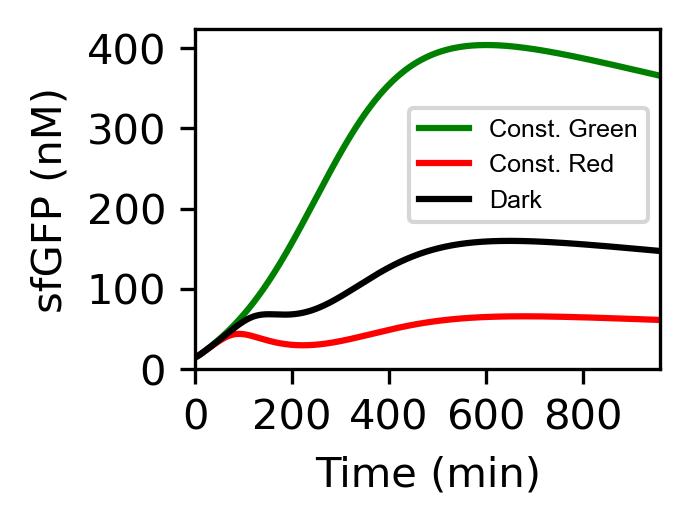

In [6]:
# Plot the protein profile for each open loop case 

fig, ax = plt.subplots(figsize=(2, 1.5), dpi = 300)

# Style
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 7,
    'axes.labelsize': 7,
    'axes.titlesize': 7,
    'legend.fontsize': 6
})
tick_fontsize = 7

# Line width and alpha
lwd_model = 1


ax.plot(time_green, sol_green[:,8], 'green', label = 'Const. Green')
ax.plot(time_red, sol_red[:,8], 'red', label = 'Const. Red')
ax.plot(time_dark, sol_dark[:,8], 'black', label = 'Dark')
ax.set_xlabel('Time (min)'); ax.set_ylabel('sfGFP (nM)')
ax.set_xlim((0, t_final)); ax.set_ylim((0))
ax.legend(loc = 'center right', bbox_to_anchor=(1, 0.6)) 

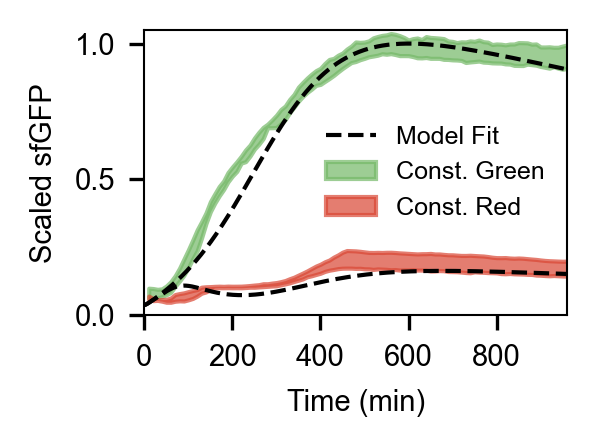

In [7]:
fig, ax = plt.subplots(figsize=(2, 1.5), dpi = 300)

# Style
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 7,
    'axes.labelsize': 7,
    'axes.titlesize': 7,
    'legend.fontsize': 6
})
tick_fontsize = 7

# Line width and alpha
lwd_model = 1
alp = 0.7

# Model curves (normalized to green model peak)
ax.plot(time_green, sol_green[:,8]/np.max(sol_green[:,8]), 'k--', linewidth=lwd_model, label='Model Fit')
ax.plot(time_red, sol_red[:,8]/np.max(sol_green[:,8]), 'k--', linewidth=lwd_model)

# Experimental shaded regions (mean ± std)
ax.fill_between(time1,
                green_mean_norm[:len(time1)] - green_std_norm[:len(time1)],
                green_mean_norm[:len(time1)] + green_std_norm[:len(time1)],
                color = color_dict['green_constant'], alpha=alp, label='Const. Green')

ax.fill_between(time1,
                red_mean_norm[:len(time1)] - red_std_norm[:len(time1)],
                red_mean_norm[:len(time1)] + red_std_norm[:len(time1)],
                color = color_dict['red_constant'], alpha=alp, label='Const. Red')

# Labels and axis limits
ax.set_xlabel('Time (min)')
ax.set_ylabel('Scaled sfGFP')
ax.set_xlim(0, 960)
ax.set_ylim(0, 1.05)
ax.set_xticks([0, 200, 400, 600, 800])
ax.set_yticks([0, 0.5, 1.0])

# Legend
ax.legend(loc='center right', frameon=False)

# Spine control
spine_width = 0.5
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_linewidth(spine_width)

# Ticks
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

# Layout and save
plt.tight_layout()
#plt.savefig('figures/c. GEAGS_model_fit.svg', format='svg', dpi=300, bbox_inches='tight', transparent=True)

In [8]:
# # To export the absolute simulation data 

# tcs_model_dict = dict()
# time_ext = np.linspace(0, t_final, 960)
# tcs_model_dict['Time'] = time_ext
# tcs_model_dict['Red'] = np.interp(time_ext, time_red, sol_red[:,8])
# tcs_model_dict['Green'] = np.interp(time_ext, time_green, sol_green[:,8])
# tcs_model_dict['Dark'] = np.interp(time_ext, time_dark, sol_dark[:,8])


# tcs_model_df = pd.DataFrame(data = tcs_model_dict)
# tcs_model_df.to_csv('TCS_growth_dependent_model_prediction_red_green_dark.csv')

In [9]:
# # To export the simulation data 

# tcs_model_dict = dict()

# tcs_model_dict['Time'] = timepoints
# tcs_model_dict['Red'] = sol_red.y[8,:]/np.max(sol_green.y[8,:])
# tcs_model_dict['Green'] = sol_green.y[8,:]/np.max(sol_green.y[8,:])

# tcs_model_dict['Green expt 1'] = green_only_1/green_max
# tcs_model_dict['Green expt 2'] = green_only_2/green_max
# tcs_model_dict['Green expt 3'] = green_only_3/green_max

# tcs_model_dict['Red expt 1'] = red_only_1/green_max
# tcs_model_dict['Red expt 2'] = red_only_2/green_max
# tcs_model_dict['Red expt 3'] = red_only_3/green_max

# tcs_model_df = pd.DataFrame(data = tcs_model_dict)
# tcs_model_df.to_csv('TCS_growth_dependent_model_prediction_red_green_scaled.csv')

In [10]:
# Visualize and export parameters
# Uncomment the commented part to export the parmeter file as a csv with desired name

param_dict = params.valuesdict()
# param_dict_guess_df = dict()
# param_dict_guess_df['Param name'] = param_dict.keys()
# param_dict_guess_df['Param'] = param_dict.values()
# param_data = pd.DataFrame(data = param_dict_guess_df)
# param_data.to_csv('TCS_params_file.csv')
param_dict

{'k_green': 0.8,
 'k_red': 1.3,
 'b_green': 0.03,
 'b_red': 1.0,
 'k_sp_b': 0.05,
 'k_sp_u': 25.0,
 'k_rp_b': 55.0,
 'k_rp_u': 0.08,
 'beta': 28.0,
 'l0': 1e-05,
 'Kc': 45.0,
 'd_m': 0.27,
 'k_tl': 2.0,
 'k_tli_b': 40.0,
 'k_tli_u': 12.0,
 'd_p': 0.0008,
 'k_fold': 0.3,
 'b_fold': 1.0,
 'n_gamma': 0.889,
 'R_max': 4.0,
 'S_0': 1.0,
 'R_0': 180.0,
 'Sp_0': 1.0,
 'Rp_0': 30.0,
 'mRNA_0': 1.0,
 'P_0': 1.0,
 'Pm_0': 15.0,
 'k_gr': 0.011,
 'C_max': 713694117.0,
 'C_0': 46870588.0,
 'n_tcs': 1.0}